# Esports Gaming Data

## Intro
Esports, or "competitive tournaments of video games, especially among professional gamers," [officially entered](https://www.pcgamer.com/esports-is-now-officially-in-the-dictionary/) the lexicon on Dictionary.com in 2015. Video game competitions have been going on for a while though! In this notebook, we'll track the evolution of the esports world from data on https://www.esportsearnings.com. 

For more esports info, check out:
* [a YouTube documentary](https://www.youtube.com/watch?v=6tgWH-qXpv8) of Super Smash Brawl competitions (remember those days? before Netflix!)
* [Vox's Explained](https://www.vox.com/2018/6/27/17505604/esports-netflix-explained-video-gaming-league-of-legends) on League of Legends
* Redbull, who [sponsors](https://www.redbull.com/us-en/athletes?filter.countryCode=US&filter.disciplineId=rrn:content:collections:91ecb926-8d6c-4aa6-8206-aa0a24ef7301,rrn:content:collections:12ae9f7e-9b8e-4439-aa8f-725db346dbfb) a team and several high-profile gamers (Ninja! as of this writing) [has a list of more](https://www.redbull.com/gb-en/best-esports-documentaries)!

I have a psql database of gaming info, with a table named 'top_historic' that lists the top 500 games per year by estimated prizes of tournaments. In that table, I have:

name | description | type
--- | --- | ---
index | index number |  bigint 
 id   |  integer of year + position (in the year) |bigint
 position | position held in the year | bigint
 game | game title | text
 year | year of tournaments | bigint
earnings | year earnings of tournament | double precision
players | number of players in tournaments | bigint
tournaments | number of tournaments | bigint

Some columns like position could be made a smaller type, since the max is 500. Plus, the index is redundant since we have no ties (positions 1-500 are uniquely assigned per year, so the id is unique). 

This data is also stored in an excel spreadsheet, which I will pull from all at once into a dataframe. Note with psql, we can just grab and play with data as needed (or all at once), whereas now we just load all the data into a dataframe. It's a small, complete, and static (historic) dataset anyway.

## The numbers

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
col_info={
    'id': int,
    'position': int,
    'game': str,
    'earnings': np.float64,
    'players': np.int32,
    'tournaments':np.int32,
    'year': int,
    'cpiurs':np.float32,
    'earnings2019usd':np.float64
    
}

In [189]:
data = pd.read_csv('data/esports_historic_combined.csv', dtype = col_info)

In [190]:
data.describe()

,id,position,earnings,players,tournaments,year,cpiurs,earnings2019usd
count,1.469000e+03,1469.000000,1.469000e+03,1469.000000,1469.000000,1469.000000,1469.000000,1.469000e+03
mean,5.049516e+05,54.209666,6.299027e+05,108.726344,28.819605,2014.085773,344.806274,6.565865e+05
std,7.130566e+05,44.940268,3.432721e+06,345.659643,90.948234,5.331593,32.540569,3.510621e+06
min,1.998100e+04,1.000000,0.000000e+00,0.000000,1.000000,1998.000000,239.500000,0.000000e+00
25%,2.008360e+05,18.000000,1.311600e+03,5.000000,1.000000,2011.000000,330.500000,1.367000e+03
50%,2.015800e+05,41.000000,2.016300e+04,19.000000,3.000000,2016.000000,353.399994,2.292400e+04
75%,2.019870e+05,82.000000,1.283232e+05,67.000000,15.000000,2018.000000,369.799988,1.425300e+05
max,2.020186e+06,186.000000,7.159813e+07,4791.000000,1018.000000,2020.000000,376.500000,7.159813e+07


In [191]:
games = data['game'].unique()

In [193]:
games_df = data.groupby('game',as_index=False).agg({'year': ['min', 'max'], 'earnings': 'sum','earnings2019usd':'sum', 'players':'sum','tournaments':'sum'})
games_df=games_df.set_index('game')
games_df = games_df.sort_values([('earnings2019usd', 'sum')], ascending=False)
games_df.head()

year            earnings earnings2019usd  \
                                   min   max           sum             sum   
game                                                                         
Dota 2                            2011  2020  2.293251e+08     238885735.0   
Counter-Strike: Global Offensive  2012  2020  1.073682e+08     110548533.0   
Fortnite                          2018  2020  9.936292e+07      99723107.0   
League of Legends                 2010  2020  8.177818e+07      85709860.0   
StarCraft II                      2010  2020  3.438917e+07      36790278.0   

                                 players tournaments  
                                     sum         sum  
game                                                  
Dota 2                              7854        1472  
Counter-Strike: Global Offensive   26371        5427  
Fortnite                            5829         673  
League of Legends                  14694        2489  
StarCraft II                        4994        6064

In [194]:
games_df['earningsPerTournament'] = games_df[('earnings','sum')]/games_df[('tournaments','sum')]

In [195]:
games_df[games_df['earningsPerTournament'] == max(games_df['earningsPerTournament'])]

year         earnings earnings2019usd players tournaments  \
         min   max        sum             sum     sum         sum   
game                                                                
TEPPEN  2019  2019  456721.47        456721.0      12           1   

       earningsPerTournament  
                              
game                          
TEPPEN             456721.47

In [196]:

games_df[games_df[('tournaments', 'sum')] == max(games_df[('tournaments', 'sum')])]

year           earnings earnings2019usd players tournaments  \
               min   max          sum             sum     sum         sum   
game                                                                        
StarCraft II  2010  2020  34389174.78      36790278.0    4994        6064   

             earningsPerTournament  
                                    
game                                
StarCraft II           5671.038057

In [197]:
games_df['yearsAlive'] = games_df[('year','max')]-games_df[('year','min')]+1

In [198]:
young_df = games_df[games_df['yearsAlive']<5]

In [12]:
young_df = young_df.sort_values([('earnings2019usd', 'sum')], ascending=False)
young_df.head(10)

year           earnings earnings2019usd  \
                                 min   max          sum             sum   
game                                                                      
Fortnite                        2018  2020  99362917.41      99723107.0   
UNKNOWN’S BATTLEGROUNDS         2017  2020  25653470.88      25847469.0   
Arena of Valor                  2017  2020  23230071.67      23354899.0   
UNKNOWN'S BATTLEGROUNDS Mobile  2018  2020   9986435.02       9997615.0   
Halo 5: Guardians               2015  2018   7061480.97       7395712.0   
Call of Duty: Black Ops 4       2018  2020   6734438.95       6740259.0   
Call of Duty: Modern Warfare    2019  2020   6617284.50       6617285.0   
Magic: The Gathering Arena      2018  2020   6012000.00       6012181.0   
Apex Legends                    2019  2020   5028771.69       5028772.0   
Call of Duty: World War II      2017  2018   4559271.00       4648610.0   

                               players tournaments earningsPerTournament  \
                                   sum         sum                         
game                                                                       
Fortnite                          5829         673         147641.779212   
UNKNOWN’S BATTLEGROUNDS           4184         323          79422.510464   
Arena of Valor                     947          60         387167.861167   
UNKNOWN'S BATTLEGROUNDS Mobile    1471          47         212477.340851   
Halo 5: Guardians                  411          75          94153.079600   
Call of Duty: Black Ops 4          489          69          97600.564493   
Call of Duty: Modern Warfare       284          45         147050.766667   
Magic: The Gathering Arena         286          38         158210.526316   
Apex Legends                      1312         273          18420.409121   
Call of Duty: World War II         315          64          71238.609375   

                               yearsAlive  
                                           
game                                       
Fortnite                                3  
UNKNOWN’S BATTLEGROUNDS                 4  
Arena of Valor                          4  
UNKNOWN'S BATTLEGROUNDS Mobile          3  
Halo 5: Guardians                       4  
Call of Duty: Black Ops 4               3  
Call of Duty: Modern Warfare            2  
Magic: The Gathering Arena              3  
Apex Legends                            2  
Call of Duty: World War II              2

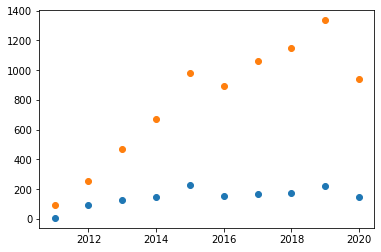

In [13]:
dota2 = data[data['game']=='Dota 2']

plt.scatter(dota2['year'],dota2['tournaments'])
plt.scatter(dota2['year'],dota2['players'])

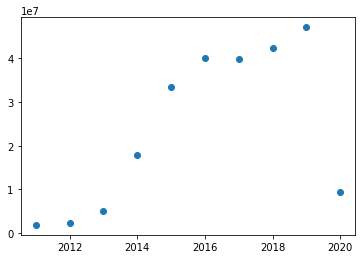

In [14]:
plt.scatter(dota2['year'],dota2['earnings2019usd'])

In [16]:
def plot_info(game_name, x,y):
    df = data[data['game']==game_name]
    plt.scatter(df[x],df[y])

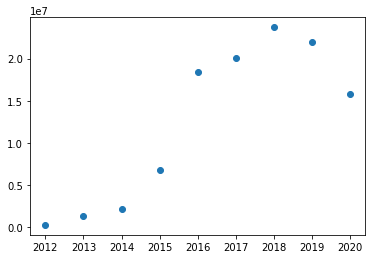

In [18]:
plot_info('Counter-Strike: Global Offensive','year','earnings2019usd')

In [236]:
gd2=games_df.groupby(np.where(games_df[('earnings2019usd', 'sum')]>=10000000,games_df.index,'Other')).sum()
color_dict =  dict(zip(fe2.index.tolist(), plt.cm.tab20.colors[:len(gd2)]))

<ipython-input-238-33c8331df90f>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0.5, 1.0, 'Historic Earnings from Esports Games')

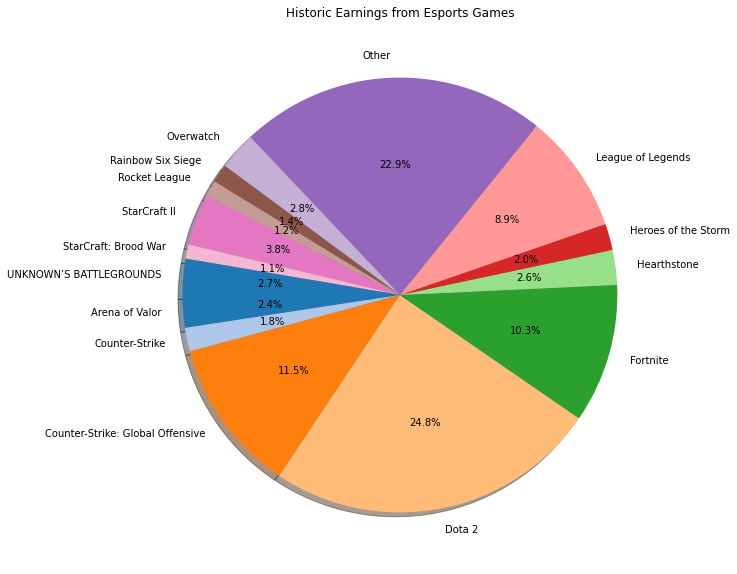

In [238]:

gd2.plot.pie(y=('earnings2019usd', 'sum'), autopct='%1.1f%%',  shadow=True,  startangle=180, legend = False, figsize=(20,10), colors = color_dict.values())
plt.axes().set_ylabel('')
plt.title('Historic Earnings from Esports Games')

<ipython-input-214-9bcaff117f46>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0.5, 1.0, 'Earnings from Top 500 Games Historically')

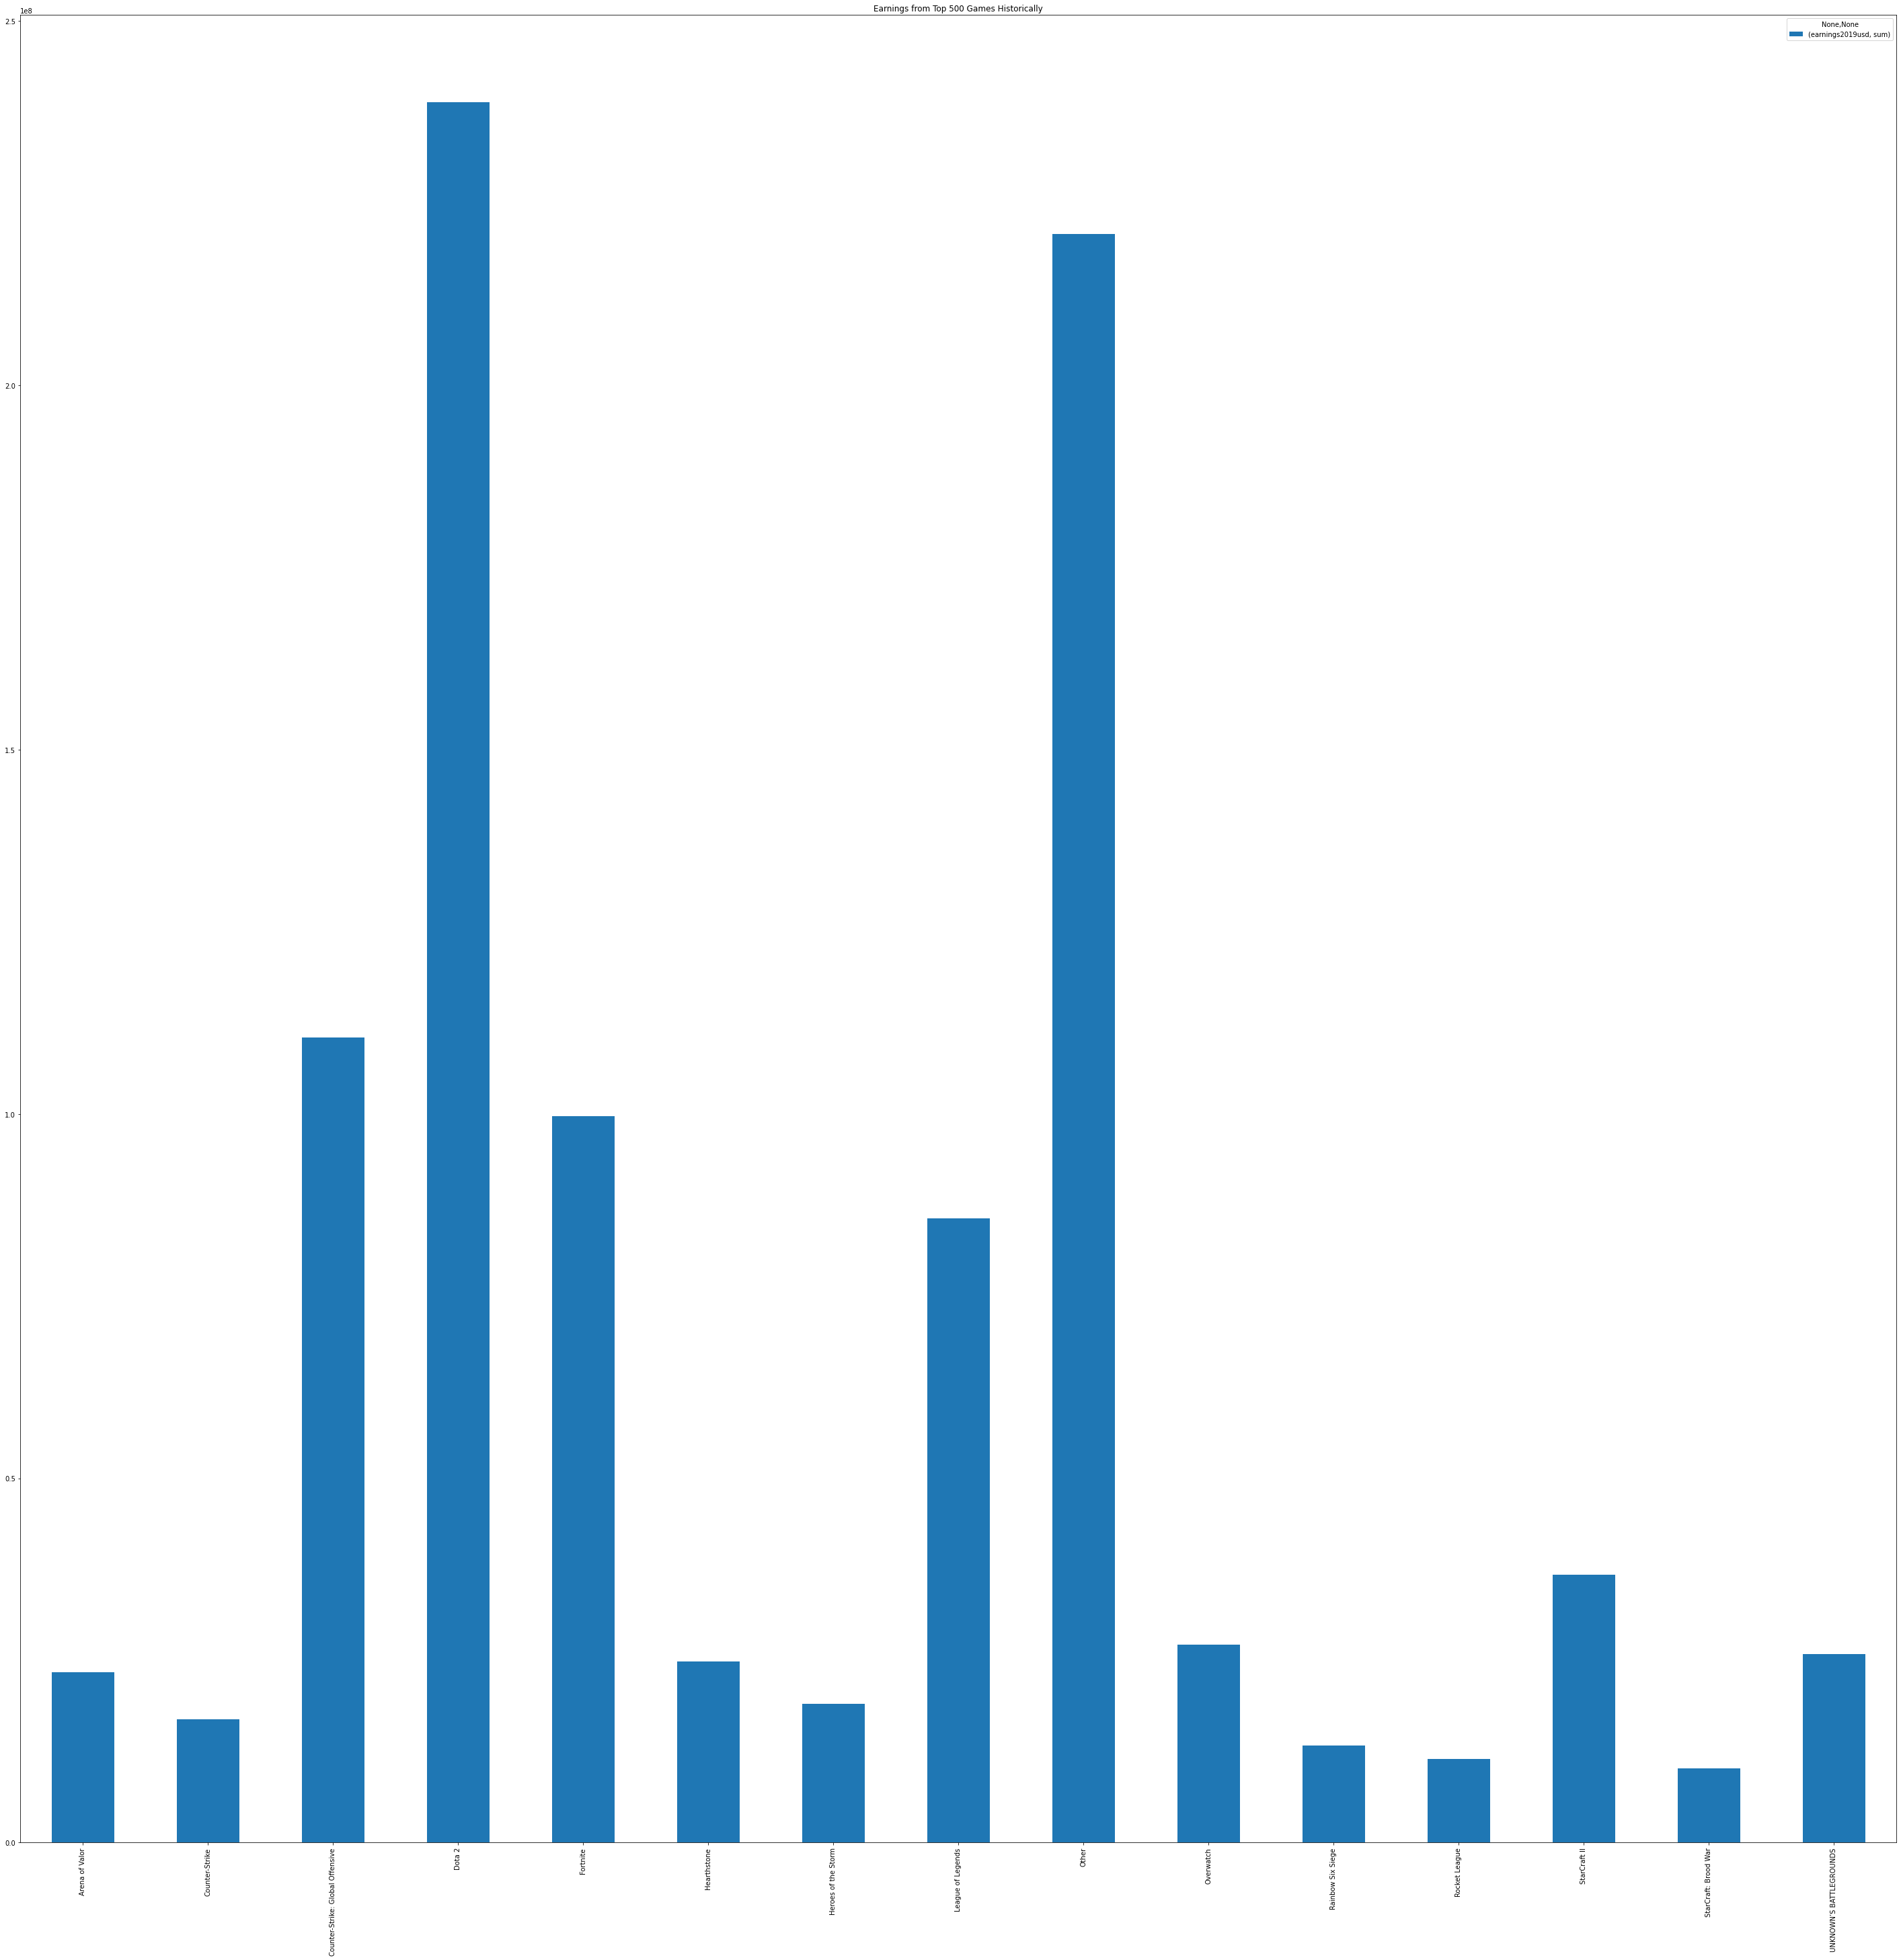

In [214]:

gd2=games_df.groupby(np.where(games_df[('earnings2019usd', 'sum')]>=10000000,games_df.index,'Other'),sort=True).sum()
color_dict =  dict(zip(gd2.index.tolist(), plt.cm.tab20.colors[:len(gd2)]))
gd2.plot.bar(y=('earnings2019usd', 'sum'),figsize=(50,50))
plt.axes().set_ylabel('')
plt.title('Earnings from Top 500 Games Historically')

## Female gamers
We have a dataset of the top 500 female players. Let's match the games with those in the general.

In [32]:
df_fem = pd.read_csv('data/esports_data/female-500.csv') 
print(df_fem.columns)

Index(['Position', 'Player ID', 'Player Name', 'Total (Overall)',
       'Highest Paying Game', 'Total (Game)', ' of Total'],
      dtype='object')


In [33]:
top_fem_games = set(df_fem["Highest Paying Game"].unique())
fem_rep = top_fem_games.intersection(set(games))

In [34]:
fem_rep

{'Among Us',
 'Apex Legends',
 'Attack on Titan Tribute Game',
 'Brawlhalla',
 'Call of Duty: Black Ops III',
 'Call of Duty: Blackout',
 'Call of Duty: Modern Warfare',
 'Call of Duty: Warzone',
 'Chess.com',
 'Counter-Strike',
 'Counter-Strike: Global Offensive',
 'CrossFire',
 'Dead By Daylight',
 'Dead or Alive 4',
 'Dota 2',
 'Fall Guys',
 'Fortnite',
 'Free Fire',
 'Gwent',
 'H1Z1',
 'Halo: Reach',
 'Hearthstone',
 'League of Legends',
 'Lichess',
 'Magic: The Gathering Arena',
 'Minecraft',
 'Overwatch',
 'Playchess.com',
 'Point Blank',
 'Prophecy',
 'Quake 4',
 'Quake III Arena',
 'Rainbow Six Siege',
 'Rocket Arena',
 'Rocket League',
 'Sea of Thieves',
 'Shadowverse',
 'Soul Calibur V',
 'StarCraft II',
 'StarCraft: Brood War',
 'Stardew Valley',
 'Street Fighter V',
 'Super Smash Bros. Melee',
 'Super Smash Bros. for Wii U',
 'Teamfight Tactics',
 'Tekken 7',
 'VALORANT',
 'Vainglory',
 'WWE 2K20',
 'Warface',
 'Zwift',
 'chess24'}

In [35]:
fem_rep = df_fem.groupby(['Highest Paying Game']).count()

In [239]:
fem_earn = df_fem.groupby(['Highest Paying Game'], as_index=False,sort=True)['Total (Game)'].sum()
fem_earn=fem_earn.set_index('Highest Paying Game')
print(fem_earn.head())

                              Total (Game)
Highest Paying Game                       
Among Us                           6000.00
Apex Legends                      44023.34
Attack on Titan Tribute Game      30100.00
Brawlhalla                         8765.00
Call of Duty: Black Ops III        1600.00


<ipython-input-240-97480b615780>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0.5, 1.0, 'Competitive Earnings from Top 500 Female Gamers')

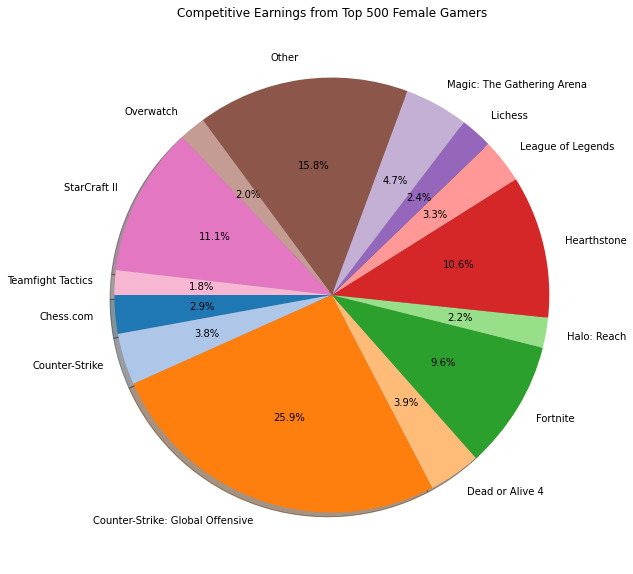

In [240]:
fe2=fem_earn.groupby(np.where(fem_earn['Total (Game)']>=75000,fem_earn.index,'Other')).sum()
color_ = {}
np.random.seed(42)
for i in fe2.index.tolist():
    if i in color_dict.keys():
        color_[i] = color_dict[i]
    else:
        color_[i]= plt.cm.tab20c.colors[np.random.randint(20)]

fe2.plot.pie(y='Total (Game)', autopct='%1.1f%%',  shadow=True,  startangle=180, legend = False, figsize=(20,10), colors = color_.values())
plt.axes().set_ylabel('')
plt.title('Competitive Earnings from Top 500 Female Gamers')

In [241]:
rep=df_fem['Highest Paying Game'].value_counts()
rep2=rep.groupby(np.where(rep>=8,rep.index,'Other')).sum()
np.random.seed(0)
color_dict2 = {}

for i in rep2.index.tolist():
    if i in color_dict.keys():
        color_dict2[i] = color_dict[i]
    else:
        color_dict2[i]= plt.cm.tab20c.colors[np.random.randint(20)]
    

<ipython-input-242-8a2632c2742b>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0.5, 1.0, 'Best Game for Top 500 Females')

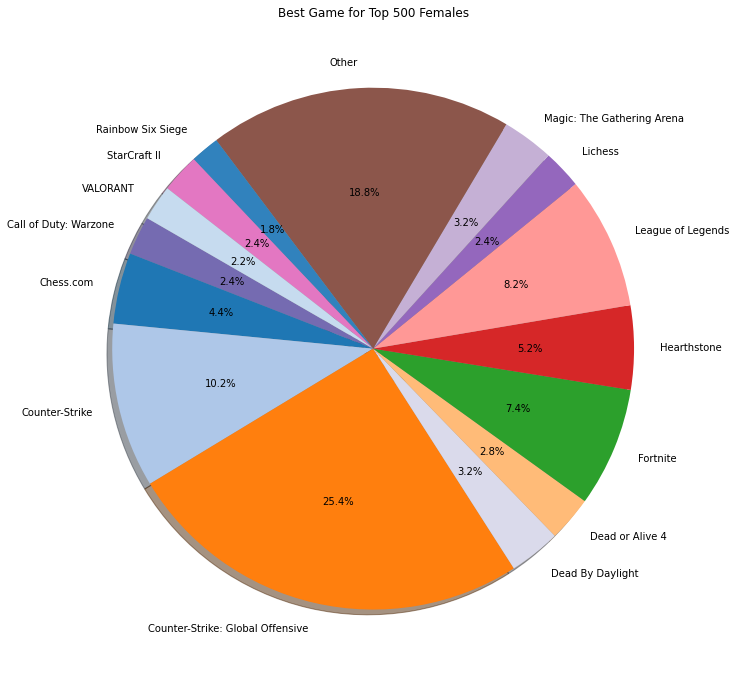

In [242]:
plt.figure(figsize=(12,12))
rep2.plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=150,colors = color_dict2.values())
plt.axes().set_ylabel('')
plt.title('Best Game for Top 500 Females')

<ipython-input-243-8b1189d9cfac>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_ylabel('')


Text(0.5, 1.0, 'Highest Paying Games for Top 500 Females')

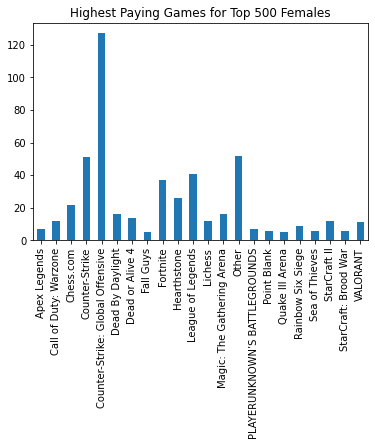

In [243]:
rep=df_fem['Highest Paying Game'].value_counts()
rep2=rep.groupby(np.where(rep>=5,rep.index,'Other')).sum().plot.bar()
plt.axes().set_ylabel('')
plt.title('Highest Paying Games for Top 500 Females')